#Assignment 3



Install dependencies

In [ ]:
!sudo apt update


!sudo apt install ffmpeg
!pip install moviepy
!ffmpeg -version
!pip install imageio-ffmpeg
!pip install pygame pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
#!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
#!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install gym[box2d]

!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
#!pip install stable-baselines[mpi]
#!pip install stable-baselines3[extra]


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 88.7 kB in 2s (51.3 kB/s)
Reading package lists... Done
Buildi

Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch 
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
#from gym.wrappers import Monitor
from gym.wrappers.record_video import RecordVideo

import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files


###################################################
###################################################
###################################################
UseRandomize=True;
UseContinuousControl=False;
###################################################
###################################################
###################################################



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Deep RL Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []
        
    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)
            
        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];
        
        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

In [ ]:
from torchvision import datasets, models
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        
        self.input_size=inputs;
        self.output_size=outputs;

        
        self.features = nn.Sequential(
            #TODO Add code here for DQN 
            #you can use the same code for dueling
            nn.Conv2d(in_channels=self.input_size, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.layers = nn.Sequential( 
            #TODO Add code here 
            nn.Linear(in_features = 4096, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = self.output_size)
        ) 


        self.layersdueling = nn.Sequential(
            #TODO Add code here
            nn.Linear(in_features = 4096, out_features = 128)
        )


        self.advantage = nn.Sequential(
            #TODO Add code here
            nn.Linear(in_features = 128, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = self.output_size)
        )
        
        self.value = nn.Sequential(
            #TODO Add code here
            nn.Linear(in_features = 128, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = 1) 
        )
        
###### DQN/Double DQN configuration 
                                                    
###########    ############    #################            
#         #    #          #    #               #    
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #  
###########    ############    #################   

   

###### Dueling configuration 
                                                    #############
###########    ############    #################    # advantage #           
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...    
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############
 

    def forward(self, x):
    
        if(useDueling):
            x=self.features(x)
            x = x.view(x.size(0), -1)
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value     = self.value(x)
            return value + advantage  - advantage.mean()
        else:
            x=self.features(x)
            x = x.view(x.size(0), -1)
            return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()
     
    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


OpenAI Environment CarRacing-v2

 
###    Description:
        Continuous or discrete control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete Mode: 'nothing','left','right','gas','brake'
        Continuous Mode: 3 different variables can be modified: steering wheel, gas, and brake. For the methods explored in this Colab, discrete control commands are reasonable (a set of control commands is provided for this mode).
###    Reward:
        The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
###    Starting State:
        The tracks and colors are randomly generated with UseRandomize=True for each episode. With UseRandomize=False, only the tracks are random.
###    Episode Termination:
        Car is too faraway from the track.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points. For this assignment a minimum of 200 points are required. 


DQN movie generation (for visual evaluation in Google Colab)

In [ ]:
def createMovie(Network,Filename,UseRandomizer,UseContinuous):
  
    env1 = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1#wrappers.Monitor(env1, './videos/'+Filename,force=True)
    envX = RecordVideo(env1, video_folder='./videos/'+Filename,  episode_trigger = lambda episode_number: True)  

 

 
    new_state, _ = envX.reset(options={"randomize": UseRandomizer})#,seed=6)


    envX.start_video_recorder()
    # ENV BUG, missing last_frame 
    envX.video_recorder.last_frame=new_state;

    
    stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;   

    while True:
        envX.render()
        
        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break
        #if reward<0 and i>InitCounter:
        #    resetStatus=resetStatus+1;
        #else:
        #    resetStatus=0
        
        stackedStateX.pop(0)
        
 
        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;     
        if done or truncated: #or resetStatus>=ResetCounter: 
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Dummy Net with random policy

In [ ]:
class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()        
        self.output_size=outputs;
        
 
    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)
     
    




Parameters

In [ ]:
 


if UseContinuousControl:
    #action space is still discretized however more actions can be selected
    action_space    = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)];


else:
    action_space=[0,1,2,3,4]    #  nothing','left','right','gas','brake'

 
n_actions=len(action_space)
MaxSteps=1000;


#hyper-parameters
#TODO set these values:
TotalEpisodes=500;
ControlSteps=3; # number of iterations the same action is executed in the environment (>=1) 
FrameStack=3 # number of consecutive frames used to represent the state (>=1) / stack size
FreezeCounter=5; # clone the model every X episodes
ResetCounter=30 # maximum number of experiences with bad performance (max=InitCounter+ResetCounter)
InitCounter=30 # minimum number of experiences per episode


BatchSize=64;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.985
discount_factor=0.95
LearningRate=0.0001
 
SaveAtCounter=50 # save model or video at every X episodes
FrameSize=3; # 3 if RGB 1 if grayscale

BufferSize=15000  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).


# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=True



Run the new netwwork with random policy

In [ ]:
randomnet=RandomNet(n_actions)
createMovie(randomnet,"random",UseRandomize,UseContinuousControl)

[MoviePy] >>>> Building video /content/gym/videos/random/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/random/rl-video-episode-0.mp4


/content/gym/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/gym/videos/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
 50%|█████     | 1/2 [00:00<00:00, 756.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/random/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/random/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/random/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:05<00:00, 185.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/random/rl-video-episode-0.mp4 



Initialization and Parameters:


In [ ]:
env = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomize, continuous=UseContinuousControl)
spec = gym.spec("CarRacing-v2")

weights = torch.load('/content/gdrive/MyDrive/BestCarRacing_499_924.2999999999934_model.ckpt')

#network DQN
policy_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net = DQN(FrameSize*FrameStack, n_actions).to(device)
policy_net.load_state_dict(weights)
target_net.load_state_dict(weights)
target_net.eval()

buffer = ReplayBuffer(BufferSize);   

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)

loss=  torch.nn.SmoothL1Loss()


DQN training

In [ ]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)

 
    if usedoubleDQN:
        #TODO Add Double DQN code here   
        q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
        with torch.no_grad():
            argmax_batch = policy_net(new_state_batch).argmax(dim=1,keepdim=True)
            q_argmax_next = torch.gather(target_net(new_state_batch),1,index=argmax_batch)
           
        q_target = (q_argmax_next * discount_factor)*(1-done_batch) + reward_batch 
        
        ll=loss(q_actual, q_target)     
    

    else: 
        q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
        with torch.no_grad():
            q_max_next, _ = target_net(new_state_batch).max(dim=1)
            q_max_next=q_max_next.reshape(-1, 1)

        q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch 
        
        ll=loss(q_actual, q_target)

    optimizer.zero_grad()
    ll.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()

    return ll.item();

In [ ]:
loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;
bestNet=copy.deepcopy(policy_net);
 

for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0
  
    new_state,_=env.reset(options={"randomize": UseRandomize})#,seed=6)
   
 
    stackedState=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96)) ).float().to(device)
   
    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())
       
    if f % SaveAtCounter == 0:
      #torch.save(policy_net.state_dict(), "v2CarRacing_"+str(f)+'_model.ckpt')
       createMovie(policy_net,"CarRacing_"+str(f),UseRandomize,UseContinuousControl)
       
    resetStatus=0;
    i=0    
    
    for F in range(MaxSteps):
        #env.render()
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action_space[action.item()])
            reward+=r
            i=i+1
            if(done or trunc):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0
            
        stackedState.pop(0)
        stackedState.append(np.rollaxis(new_state, 2, 0).copy())
        new_state=torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96))).float().to(device)
        
        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(state, action, torch.tensor(reward), new_state, torch.tensor(int(done)))
            
        state = new_state
        trainModel(buffer)


        if(done or trunc or resetStatus>=ResetCounter):
            break        
    exploration_threshold= exploration_threshold*exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    if(score>bestScore):
        print("Best EP: ",score," It: ",F*ControlSteps)
        bestScore=score;
        bestNet=copy.deepcopy(policy_net);
        at=f;
    
    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))


torch.save(bestNet.state_dict(), "BestCarRacing_"+str(f)+'_'+str(bestScore)+'_model.ckpt')

Output hidden; open in https://colab.research.google.com to view.

Plot performance

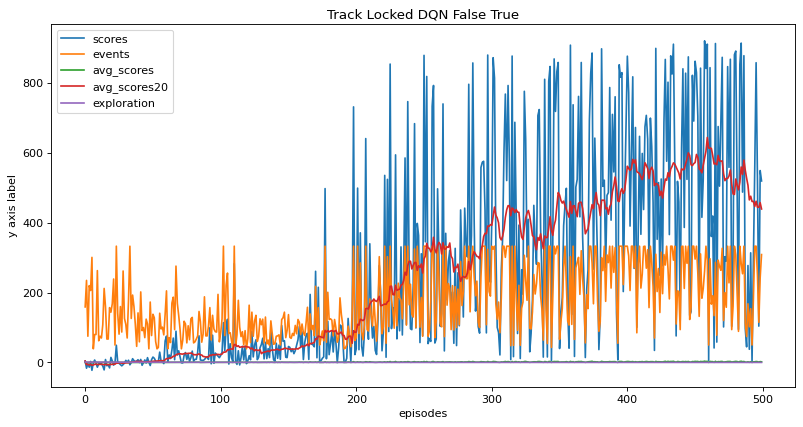

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')
 
plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores20','exploration'])
plt.show()

View Best Results

In [ ]:
createMovie(bestNet,'bestNet',UseRandomize,UseContinuousControl)




[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 364.28it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:07<00:00, 132.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



Validation Scenarios (5 with random track and 5 with random track and random environment)



In [ ]:
#TODO Add Validation code here, you can adapt the createMovie function to return the totalReward per episode


In [ ]:
def TotalReward(Network,Filename,UseRandomizer,UseContinuous):
  
    env1 = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1#wrappers.Monitor(env1, './videos/'+Filename,force=True)
    envX = RecordVideo(env1, video_folder='./videos/'+Filename,  episode_trigger = lambda episode_number: True)  
 
    new_state, _ = envX.reset(options={"randomize": UseRandomizer})#,seed=6)

    envX.start_video_recorder()
    # ENV BUG, missing last_frame 
    envX.video_recorder.last_frame=new_state;
   
    stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)

    i=0
    Network.eval()
    resetStatus=0;   
    score = 0;

    while True:
        envX.render()
        
        action = Network.policy(state);
        
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break
        #if reward<0 and i>InitCounter:
        #    resetStatus=resetStatus+1;
        #else:
        #    resetStatus=0
        
        stackedStateX.pop(0)
        score += reward
        
        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)

        i=i+1;     
        if done or truncated: #or resetStatus>=ResetCounter: 
          break;
      
    #print("score: {}".format(score))
     
    envX.close()
    env1.close();
    Network.train()
    return score

In [ ]:
# 5 with random track
for i in range(5):
  reward = TotalReward(bestNet,'bestNet',False,UseContinuousControl)
  print("Comb {}: {}".format(i,reward))

print("-----")

# 5 with random track and random environment
for j in range(5,10):
  reward = TotalReward(bestNet,'bestNet',True,UseContinuousControl)
  print("Comb {}: {}".format(j,reward))


[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


/content/gym/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/gym/videos/bestNet folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
 50%|█████     | 1/2 [00:00<00:00, 536.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:07<00:00, 135.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 0: 611.0676056337875
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 276.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 844/844 [00:06<00:00, 131.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 1: 520.2673539518797
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 801.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 335/335 [00:02<00:00, 156.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 2: -58.201185770751366
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 803.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 480/480 [00:03<00:00, 154.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 3: -45.03320158102639
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 752.75it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 578/578 [00:04<00:00, 143.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 4: 114.84582043343877
-----
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 782.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:07<00:00, 142.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 5: 895.8317460317325
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 444.45it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 852/852 [00:06<00:00, 138.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 6: 914.7999999999861
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 825.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:07<00:00, 140.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 7: 783.7590443685841
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 820.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 536/536 [00:03<00:00, 155.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 8: 264.71846689895034
[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


 50%|█████     | 1/2 [00:00<00:00, 800.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 



[MoviePy] >>>> Building video /content/gym/videos/bestNet/rl-video-episode-0.mp4
[MoviePy] Writing video /content/gym/videos/bestNet/rl-video-episode-0.mp4


100%|██████████| 1001/1001 [00:10<00:00, 99.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gym/videos/bestNet/rl-video-episode-0.mp4 

Comb 9: 59.66394557823551
